In [ ]:
!pip3 install kaggle

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [ ]:
api = KaggleApi()

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
api.authenticate()

In [ ]:
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'test.tsv.zip', path='./')
api.competition_download_file('sentiment-analysis-on-movie-reviews',
                              'train.tsv.zip', path='./')

100%|██████████| 494k/494k [00:00<00:00, 29.9MB/s]

100%|██████████| 1.28M/1.28M [00:00<00:00, 31.3MB/s]

In [ ]:
import zipfile

In [ ]:
with zipfile.ZipFile('./test.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

In [ ]:
with zipfile.ZipFile('./train.tsv.zip', 'r') as zipref:
    zipref.extractall('./')

## Preprocess

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('train.tsv', sep = "\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [ ]:
df = df.drop(df[df['SentenceId'] > 0].sample(frac=.99).index)

In [ ]:
df.shape

(1561, 4)

In [ ]:
import matplotlib

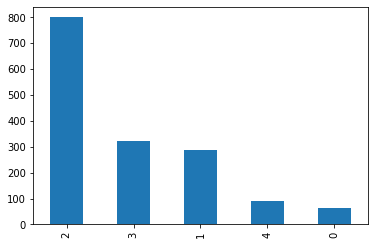

In [ ]:
df['Sentiment'].value_counts().plot(kind='bar')

In [ ]:
seq_len = 512
num_samples = len(df)

num_samples, seq_len

(1561, 512)

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 6.8 MB 38.2 MB/s 
     |████████████████████████████████| 67 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 47.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='np')

In [ ]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokens['input_ids']

array([[  101,  3084,  7272, ...,     0,     0,     0],
       [  101,   117, 16793, ...,     0,     0,     0],
       [  101,   138,  9705, ...,     0,     0,     0],
       ...,
       [  101,  1132,  1304, ...,     0,     0,     0],
       [  101,  1110,  5574, ...,     0,     0,     0],
       [  101,  1114,  1142, ...,     0,     0,     0]])

In [ ]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
import numpy as np

with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [ ]:
arr = df['Sentiment'].values

In [ ]:
arr.shape

(1561,)

In [ ]:
arr

array([2, 2, 2, ..., 0, 1, 2])

In [ ]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(1561, 5)

In [ ]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [ ]:
labels[np.arange(num_samples), arr] = 1

In [ ]:
labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [ ]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

In [ ]:
import tensorflow as tf

## Building dataset

In [ ]:
import numpy as np

with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [ ]:
print(Xids.shape)
print(Xmask.shape)
print(labels.shape)

(1561, 512)
(1561, 512)
(1561, 5)


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

In [ ]:
dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(512,), dtype=tf.int64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

## Dataset Shuffle, Batch, Split, and Save

In [ ]:
batch_size = 16

In [ ]:
dataset = dataset.shuffle(100000).batch(batch_size, drop_remainder=True)

In [ ]:
dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [ ]:
dataset

<BatchDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [ ]:
split = 0.9

size = int((Xids.shape[0] / batch_size) * split)

size

87

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [ ]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [ ]:
train_ds.element_spec

({'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
train_ds.element_spec == val_ds.element_spec

True

In [ ]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

##  Build and Save

In [ ]:
from transformers import TFAutoModel

In [ ]:
import tensorflow as tf

In [ ]:
bert = TFAutoModel.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
bert.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Two inputs
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int64')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int64')

In [ ]:
# Transformer
embeddings = bert.bert(input_ids, attention_mask=mask)[0]

In [ ]:
# Classifier
x = tf.keras.layers.Dropout(0.1)(embeddings)
x = tf.keras.layers.GlobalMaxPool1D()(x)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [ ]:
# Initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

In [ ]:
# Freeze layer
model.layers[2].trainable = False

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [ ]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [ ]:
# Load sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

In [ ]:
# View input
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3)

Epoch 1/3
87/87 [==============================] - 140s 2s/step - loss: 1.9470 - accuracy: 0.4303 - val_loss: 1.3763 - val_accuracy: 0.5250
Epoch 2/3
87/87 [==============================] - 129s 1s/step - loss: 1.6422 - accuracy: 0.4914 - val_loss: 1.0880 - val_accuracy: 0.5375
Epoch 3/3
87/87 [==============================] - 129s 1s/step - loss: 1.4812 - accuracy: 0.5180 - val_loss: 1.0104 - val_accuracy: 0.5500


In [ ]:
model.save('sentiment_model')

INFO:tensorflow:Assets written to: sentiment_model/assets


INFO:tensorflow:Assets written to: sentiment_model/assets


In [ ]:
!zip -r /content/sentiment_model.zip /content/sentiment_model

  adding: content/sentiment_model/ (stored 0%)
  adding: content/sentiment_model/keras_metadata.pb (deflated 95%)
  adding: content/sentiment_model/assets/ (stored 0%)
  adding: content/sentiment_model/saved_model.pb (deflated 92%)
  adding: content/sentiment_model/variables/ (stored 0%)
  adding: content/sentiment_model/variables/variables.index (deflated 76%)
  adding: content/sentiment_model/variables/variables.data-00000-of-00001 (deflated 7%)


In [ ]:
from google.colab import files
files.download("/content/sentiment_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = tf.keras.models.load_model('sentiment_model')

model.summary()

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
probs = model.predict(prep_data("intermittently pleasing but mostly routine"))[0]

probs

In [ ]:
import numpy as np

np.argmax(probs)

In [ ]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('test.tsv', sep='\t')
df.head()

In [ ]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

In [ ]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

In [ ]:
df.tail()


In [ ]:
!zip -r /content/file.zip /content/Folder_To_Zip


In [ ]:
from google.colab import files
files.download("/content/sentiment_model")

In [ ]:
!zip -r /content/sentiment_model.zip /content/sentiment_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')